# Notebook to tune Echo State network

### Summary from the paper 'A practical guide to applying echo state networks'
This section gives a summary of the 'general wisdoms' presented in the paper on how to handle an ESN. 

### Parameters 

##### Reservoir size
A bigger reservoir results in better approximation of a signal GIVEN appropriate regularization. Thus for highly complex signals that need to be modeled, use as big a reservoir as you can afford computationally. However, starting with a very large reservoir can be cumbersome. Therefore, select global parameters with a smaller reservoir size, then scale to a bigger one. Good parameters are usually transferable to bigger reservoirs (but some trials with big reservoirs can also be done to confirm this). A lower bound for the reservoir size N x can roughly be estimated by considering the number of independent real values that the reservoir must remember from the input to successfully accomplish the task.

##### Sparsity 
In the origional ESN publication it is recommended to make the reservoir connections sparse. That is, make most of the elements in W_in (CHECK THIS? WHY W_in?) equal to zero. This results in slightly better performance and enables fast reservoir updates. However, sparsity of the reservoir does not affect hte performanc much ans this paramater has a low priority to be optimized. It is therefore ignored in this paper.

##### Spectral radius
The spectral radius (rho) is the maximum absolute eigenvalue of the matrix W. It scales the width of the distrbiution of its nonzero elements. For the ESN approach to work, the reservoirs should satisfy the echo state property. That is, for a long enough input u(n), the reseroir state x(n) should not depend on the initial state of x(n). 
Large rho can lead to chaotic reservoirs that violate the echo state property. rho smaller than 1 ensures the echo state property in most cases. As a guiding principle, rho should be set large for tasks where a more exntensive history of the input is required, and small for tasks where the output y(n) depends more heavily on the current input u(n). i.e. rho should be great in tasks requiring longer memory of the input.

##### Input and bias scaling
It works best to scale the input and bias seperatly. Adtionally, it is even better to scale the columns of W_in seperately aswell. However, for simplicity, we scale the matrix W_in with a single value.
Input sclaing determines how nonlinear the reservoir rsponses are. For very linear tasks, W_in should be small. This results in the internal neurons operate around the 0 point where their activation is virtually linear (tanh). For large W_in, the units will get saturared and squished to their max activation 1, -1. Like a binary switching manner. Rho also affects non-linearity, but it can only be scaled so much untill the reservoir becomes unstable.
The amount of non linearity a task requires is not easy to judge. Finding a good tuning value is easier with experience. This parameter will have to be scaled by trial and error. 
The scaling of W_in together with spectral radius Rho determines the proportion of how much the current state x(n) depends on the current input u(n).

##### Leaking rate
The leaking rate alpha can be regarded as the speed of the reservoir update dynamics discretized in time. This leaking rate can be adapted such that different internal units have different leaking rates (so alpha is a vector), but for simplicity we stick to a single scalar. 
Alpha should be set to mathc the speed of the dynamcis of u(n) and/or y_target(n).This can, again, be difficult and subjective to determine in some cases Especially when the timescales of u(n) and y target (n) are quite different. This is one more of the global parameters to be tuned by trial and error.

### Tuning

The three main parameters to optimize are:
- Input scaling / bias scaling
- Spectral radius
- Leaking rate

The reservoir size almost comes as an external paramater, and the rest of the design choices (sampling distribution of weights, sparsity) have a lower priority. They will therefore not be tuned for simplicity. 

It is important to note that randomly generated reservoirs with identical parameters can yield different performance. This variation tends to be higher with smaller reservoirs. To elimante this effect, either average performance over several reservoir samples, or set a seed for the weight sampling. It should be noted that a seed gives a risk over paramater overfitting to a particular randomly generated W matrix. 

When tuning parameters by hand, change one parameter at the time. Once a good paramater is established, move to the next one. A nice bonus is that PAPER notes that Typically, good average performance is not found in a very narrow parameter range, thus a very
detailed fine-tuning of parameters does not give a significant improvement and is not necessary.

Aditionally it is very helpful to plot the reservoir activation signals x(n) to have a 'feel' of what is happening inside the reservoir. 

When having computed the readout weights, inspect the weights. Large values in W_out might be an indication of very sensitive and unstable solution. 

Select regularization param B for a concerte ESN using validation, without rerunning the reservoir through the training data. 

Get rid of 'washout time' aka initial transient. The initial transient is in essence a result of an arbitrary setting of x(0), which is typically
x(0) = 0. This introduces an unnatural starting state which is not normally visited once the network
has “warmed up” to the task. The amount of time steps to discard depends on the memory of the
network (which in turn depends on reservoir parameters), and typically are in the order of tens or hundreds.


### Method
The method to tune paramaters is as follows:
The parameters will be tuned one by one, when the optimal value is found, a next parameter is optimized. The default values are:
- reservoir_size=500,
- leaking_rate=1.0
- spectral_radius=1.0
- washout_time=0
- starting_state='zeros'
- ridge_param=0
- W_in_scaling=1.0
- W_fb_scaling=0 
- bias_scaling=1.0
- activation_func='tanh'

We observed that generally, larger reservoir sizes lead to high training scores. However, if the reservoir sizes got too big the training got too expensive. We therefore decided on a reservoir size of 500, providing the model with some flexibility whilst keeping the computation cost at a reasonable bound. 

The parameters that need to be determined will be determined in the following order:
- Input scaling
- Bias scaling
- spectral radius
- leaking parameter

In order to determine the optimal value for a given parameter the reservoir is randomly initialized and trained K times with the parameters set to their given values. The training accuracy is then recorded and averaged over the K runs to account for variability in performance due to random initialization of the reservoir. K was set to 5 in this case. The reason that we decided to optimize the ESN with respect to the training classification is because it was observed in early trials that the network tends to underfit. That is, the training data cannot be learned with 100%. Optimizing the network with respect to a validation accuracy might yield a network that is too 'rigid' without any regularization being applied. When an optimal value for a given parameter is found, the parameter is set to this value and the next parameter is tested. 

Once all optimal values have been found, the reservoir is upscaled in size until a 100% training accuracy was achieved. Only now the washout time is determined and an optimal regularization parameter for ridge regression was searched. 


## Tuning parameters

In [2]:
import numpy as np
from esn import ESN
from data_io.model_data import convert_raw_to_training_data, load_data_raw

K = 5
RESERVOIR = 500
W_IN = 1
BIAS = 1
SP = 1
LEAKING = 1
RIDGE_PARAM = 0

WASHOUT_TIME = 0



In [3]:
midi_raw = load_data_raw('F.txt')[:-16, :]
data, ove, ive = convert_raw_to_training_data(
    midi_raw, window_length=1, flatten_output=True)

u, y = data

In [62]:
def run_k_times(k):
    avg_acc = 0
    for _ in range(k):
        model = ESN(u.shape[1], y.shape[1], reservoir_size=RESERVOIR, W_in_scaling=W_IN, 
            bias_scaling=BIAS, spectral_radius=SP, leaking_rate=LEAKING, ridge_param=RIDGE_PARAM, ive=ive, ove=ove)
        acc, mse = model.fit(u, y)
        avg_acc += acc
    return avg_acc / k

In [100]:
def val_k_times(k, u_train, u_test, y_train, y_test):
    avg_val_acc = 0
    avg_train_acc = 0
    for _ in range(k):
        model = ESN(u.shape[1], y.shape[1], reservoir_size=RESERVOIR, W_in_scaling=W_IN, 
            bias_scaling=BIAS, spectral_radius=SP, leaking_rate=LEAKING, ridge_param=RIDGE_PARAM, 
            ive=ive, ove=ove, washout_time=WASHOUT_TIME)
        train_acc, train_mse = model.fit(u_train, y_train)
        avg_train_acc += train_acc

        val_acc = model.validate(u_test, y_test)
        avg_val_acc += val_acc
        
    return avg_val_acc / k, avg_train_acc / k

#### Input scaling

In [64]:
W_in_scaling = np.arange(0.1, 1.1, 0.1)
high_score = 0
best_param = None
for s in W_in_scaling:
    W_IN = s
    acc = run_k_times(K)
    print(f'Scaling: {s:.3f} Average training acc: {acc:.3f}')
    if acc > high_score:
        high_score = acc
        best_param = s

print(f'Param: {best_param:.3f} With highest training acc: {high_score:.3f}')


Scaling: 0.100 Average training acc: 0.844
Scaling: 0.200 Average training acc: 0.843
Scaling: 0.300 Average training acc: 0.845
Scaling: 0.400 Average training acc: 0.842
Scaling: 0.500 Average training acc: 0.841
Scaling: 0.600 Average training acc: 0.842
Scaling: 0.700 Average training acc: 0.840
Scaling: 0.800 Average training acc: 0.841
Scaling: 0.900 Average training acc: 0.840
Scaling: 1.000 Average training acc: 0.840
Param: 0.300 With highest training acc: 0.845


In [65]:
W_IN = 0.3

### Bias scaling

In [68]:
bias_scaling = np.arange(0.1, 2, 0.1)
high_score = 0
best_param = None
for s in bias_scaling:
    BIAS = s
    acc = run_k_times(K)
    print(f'Scaling: {s:.3f} Average training acc: {acc:.3f}')
    if acc > high_score:
        high_score = acc
        best_param = s

print(f'Param: {best_param:.3f} With highest training acc: {high_score:.3f}')

Scaling: 0.100 Average training acc: 0.841
Scaling: 0.200 Average training acc: 0.841
Scaling: 0.300 Average training acc: 0.842
Scaling: 0.400 Average training acc: 0.842
Scaling: 0.500 Average training acc: 0.843
Scaling: 0.600 Average training acc: 0.843
Scaling: 0.700 Average training acc: 0.843
Scaling: 0.800 Average training acc: 0.843
Scaling: 0.900 Average training acc: 0.844
Scaling: 1.000 Average training acc: 0.844
Scaling: 1.100 Average training acc: 0.843
Scaling: 1.200 Average training acc: 0.843
Scaling: 1.300 Average training acc: 0.844
Scaling: 1.400 Average training acc: 0.843
Scaling: 1.500 Average training acc: 0.842
Scaling: 1.600 Average training acc: 0.843
Scaling: 1.700 Average training acc: 0.843
Scaling: 1.800 Average training acc: 0.842
Scaling: 1.900 Average training acc: 0.843
Param: 0.900 With highest training acc: 0.844


In [69]:
BIAS = 0.9

### Spectral radius

In [70]:
spectral_radius = np.arange(0.5, 1.6, 0.1)
high_score = 0
best_param = None
for s in spectral_radius:
    SP = s
    acc = run_k_times(K)
    print(f'Scaling: {s:.3f} Average training acc: {acc:.3f}')
    if acc > high_score:
        high_score = acc
        best_param = s

print(f'Param: {best_param:.3f} With highest training acc: {high_score:.3f}')

Scaling: 0.500 Average training acc: 0.836
Scaling: 0.600 Average training acc: 0.838
Scaling: 0.700 Average training acc: 0.839
Scaling: 0.800 Average training acc: 0.843
Scaling: 0.900 Average training acc: 0.843
Scaling: 1.000 Average training acc: 0.844
Scaling: 1.100 Average training acc: 0.843
Scaling: 1.200 Average training acc: 0.843
Scaling: 1.300 Average training acc: 0.839
Scaling: 1.400 Average training acc: 0.833
Scaling: 1.500 Average training acc: 0.822
Param: 1.000 With highest training acc: 0.844


In [71]:
SP = 1.0

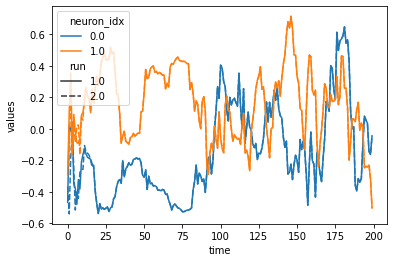

In [72]:
esn = ESN(u.shape[1], y.shape[1], reservoir_size=RESERVOIR, W_in_scaling=W_IN, 
        bias_scaling=BIAS, spectral_radius=SP, leaking_rate=LEAKING, ridge_param=RIDGE_PARAM, ive=ive, ove=ove)
esn.fit(u, y)
esn.determine_washout_time(u, y, 2, 200)

### Leaking parameter

In [74]:
leaking_param = np.arange(0.1, 1.1, 0.05)
high_score = 0
best_param = None
for s in leaking_param:
    LEAKING = s
    acc = run_k_times(K)
    print(f'Scaling: {s:.3f} Average training acc: {acc:.3f}')
    if acc > high_score:
        high_score = acc
        best_param = s

print(f'Param: {best_param:.3f} With highest training acc: {high_score:.3f}')

Scaling: 0.100 Average training acc: 0.858
Scaling: 0.150 Average training acc: 0.848
Scaling: 0.200 Average training acc: 0.842
Scaling: 0.250 Average training acc: 0.839
Scaling: 0.300 Average training acc: 0.837
Scaling: 0.350 Average training acc: 0.836
Scaling: 0.400 Average training acc: 0.835
Scaling: 0.450 Average training acc: 0.837
Scaling: 0.500 Average training acc: 0.837
Scaling: 0.550 Average training acc: 0.838
Scaling: 0.600 Average training acc: 0.839
Scaling: 0.650 Average training acc: 0.841
Scaling: 0.700 Average training acc: 0.842
Scaling: 0.750 Average training acc: 0.843
Scaling: 0.800 Average training acc: 0.843
Scaling: 0.850 Average training acc: 0.845
Scaling: 0.900 Average training acc: 0.845
Scaling: 0.950 Average training acc: 0.844
Scaling: 1.000 Average training acc: 0.843
Scaling: 1.050 Average training acc: 0.842
Param: 0.100 With highest training acc: 0.858


In [75]:
LEAKING = 0.1

### Scale to bigger reservoir

In [ ]:
reservoir_sizes = np.arange(500, 2500, 250)
high_score = 0
best_param = None
for s in reservoir_sizes:
    RESERVOIR = s
    acc = run_k_times(K)
    print(f'Scaling: {s:.3f} Average training acc: {acc:.3f}')
    if acc > high_score:
        high_score = acc
        best_param = s

print(f'Param: {best_param:.3f} With highest training acc: {high_score:.3f}')

In [96]:
RESERVOIR = 2000

### Found parameters are:

In [95]:
esn = ESN(u.shape[1], y.shape[1], reservoir_size=RESERVOIR, W_in_scaling=W_IN, 
        bias_scaling=BIAS, spectral_radius=SP, leaking_rate=SP, ridge_param=RIDGE_PARAM, ive=ive, ove=ove)
esn.fit(u, y)

(0.972681901759916, 0.08005395247230856)

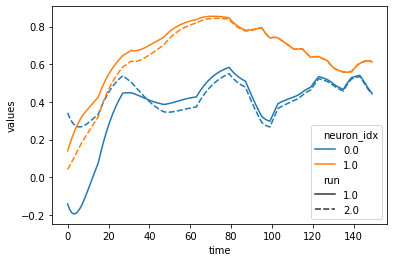

In [91]:
esn.determine_washout_time(u, y, 2, 150)

In [102]:
WASHOUT_TIME = 140

Max value weights: 124.636 Min value weights: -120.555


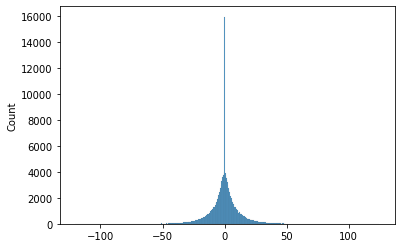

In [92]:
esn.plot_readout_weights()

In [103]:
print(f'Reservoir size = {RESERVOIR}')
print(f'Input scaling = {W_IN}')
print(f'Bias scaling = {BIAS}')
print(f'Spectral radius = {SP}')
print(f'Leaking param = {LEAKING}')
print(f'Washout time = {WASHOUT_TIME}')

Reservoir size = 2000
Input scaling = 0.3
Bias scaling = 0.9
Spectral radius = 1.0
Leaking param = 0.1
Washout time = 140


- Reservoir size = 2000
- Input scaling = 0.3
- Bias scaling = 0.9
- Spectral radius = 1.0
- Leaking param = 0.1
- Washout time = 140

### Regularization

In [99]:
from sklearn.model_selection import train_test_split

u_train, u_test, y_train, y_test = train_test_split(u, y, test_size=0.2, shuffle=False)


In [108]:
reg_strength = np.arange(8, 15, 1)
high_score_val = 0
high_score_train = 0
best_param = None
for s in reg_strength:
    RIDGE_PARAM = s
    val_acc, train_acc = val_k_times(1, u_train, u_test, y_train, y_test)
    print(f'Scaling: {s:.3f} Average validation acc: {val_acc:.3f} Average training acc: {train_acc:.3f}')
    if val_acc > high_score_val:
        high_score_val = val_acc
        high_score_train = train_acc
        best_param = s

print(f'Param: {best_param:.3f} With highest validation acc: {high_score_val:.3f} and with highest training acc: {high_score_train:.3f}')

Scaling: 8.000 Average validation acc: 0.473 Average training acc: 0.677
Scaling: 9.000 Average validation acc: 0.478 Average training acc: 0.672
Scaling: 10.000 Average validation acc: 0.482 Average training acc: 0.663
Scaling: 11.000 Average validation acc: 0.479 Average training acc: 0.658
Scaling: 12.000 Average validation acc: 0.481 Average training acc: 0.648
Scaling: 13.000 Average validation acc: 0.481 Average training acc: 0.645
Scaling: 14.000 Average validation acc: 0.476 Average training acc: 0.641
Param: 10.000 With highest validation acc: 0.482 and with highest training acc: 0.663


Best ridge param: 10.000 Average validation acc: 0.482 Average training acc: 0.663

In [109]:
RIDGE_PARAM = 10

## Final Model

In [4]:
RESERVOIR = 2000
W_IN = 0.3
BIAS = 0.9
SP = 1.0
LEAKING = 0.1
WASHOUT_TIME = 140
RIDGE_PARAM = 10

In [10]:
model = ESN(u.shape[1], y.shape[1], reservoir_size=RESERVOIR, W_in_scaling=W_IN, 
    bias_scaling=BIAS, spectral_radius=SP, leaking_rate=LEAKING, ridge_param=1, 
    ive=ive, ove=ove, washout_time=WASHOUT_TIME)
model.fit(u, y)

(0.7960867193891464, 0.1117912620954136)

Max value weights: 0.435 Min value weights: -0.423


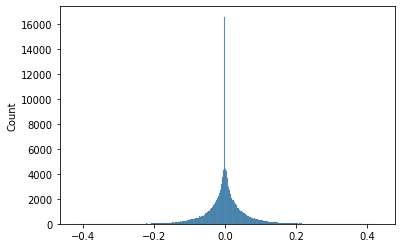

In [126]:
model.plot_readout_weights()

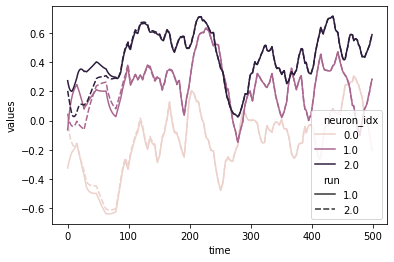

In [127]:
model.determine_washout_time(u, y, 3, 500)

In [11]:
from data_io.midi_file import MODULATION, TEMPO, midi_tones_to_midi_file

u_drive = u[-300:, :]
y_drive = y[-300:, :]
predicted_sequence = model.predict_sequence(u_drive, y_drive, 600)

output_file = "output_midi_files/pred_esn_mc.mid"
midi_tones_to_midi_file(predicted_sequence, str(output_file), tempo = TEMPO, modulation = MODULATION)